In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
player_df = pd.read_csv('player_ids.csv')

player_df.head()

,player_name,dg_id
0,"Echavarria, Nico",22833
1,"Finau, Tony",11676
2,"Hoge, Tom",15575
3,"Rose, Justin",6093
4,"Putnam, Andrew",14704


In [117]:
PCA = pd.read_csv('PCA_output.csv')

PCA.head()

,dg_id,season,PC1,PC2,sg_putt,sg_arg,sg_app,sg_ott
0,44,2024,-4.443195,2.649583,1.25950,-1.19450,-3.05550,-0.7565
1,612,2024,-2.641805,2.520068,-0.65350,-0.80400,-2.49850,-2.9090
2,653,2024,-1.144612,0.867016,-0.51075,-0.01275,-0.48375,-0.6705
3,863,2024,-4.581898,1.031630,-1.48800,-1.33650,-2.73000,-3.5900
4,874,2024,-7.147164,1.022593,-2.10600,0.35500,-4.93400,-0.8790


In [118]:
pc_cols = ["PC1", "PC2"]

scaler = StandardScaler()
PCA[pc_cols] = scaler.fit_transform(PCA[pc_cols])

In [119]:
key_cols = ['dg_id', 'season']

feature_cols = [col for col in PCA.columns if col not in key_cols]

X = PCA[feature_cols].to_numpy()

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

In [120]:
k_min, k_max = 2, 8
ks, inertias, sils = [], [], []
best_k, best_sil = None, -1

for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(Xz)
    
    if len(np.unique(labels)) < 2 or min((labels == c).sum() for c in np.unique(labels)) < 2:
        sil = -1.0
    else:
        sil = silhouette_score(Xz, labels)
        
    ks.append(k)
    inertias.append(km.inertia_)
    sils.append(sil)
    if sil > best_sil:
        best_k, best_sil = k, sil
        
best_k, best_sil

ks, sils

([2, 3, 4, 5, 6, 7, 8],
 [0.38589494602284624,
  0.21066605815570028,
  0.19557410947240622,
  0.1913810865641324,
  0.17609368645569395,
  0.12565331370959276,
  0.17644676998198838])

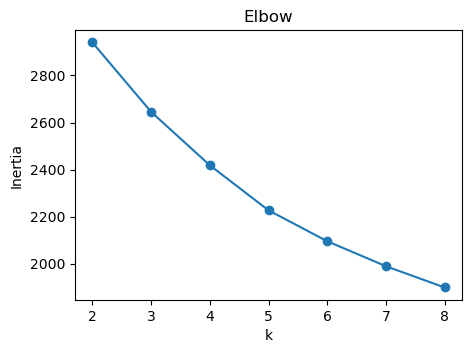

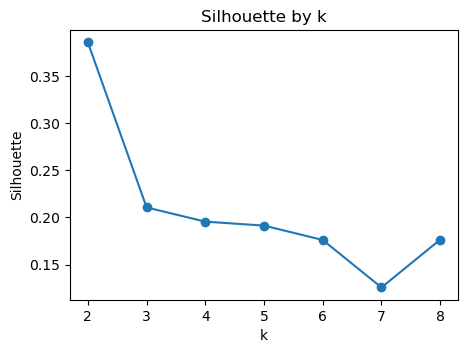

In [121]:
plt.figure(figsize=(5,3.5))
plt.plot(ks, inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow")
plt.show()

plt.figure(figsize=(5,3.5))
plt.plot(ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette by k")
plt.show()

In [122]:
km = KMeans(n_clusters=5, n_init=10, random_state=0)
labels = km.fit_predict(Xz)

clusters_df = PCA.copy()
clusters_df["cluster"] = labels
clusters_df["cluster"].value_counts().sort_index()

cluster
0     95
1     55
2    115
3    301
4     78
Name: count, dtype: int64

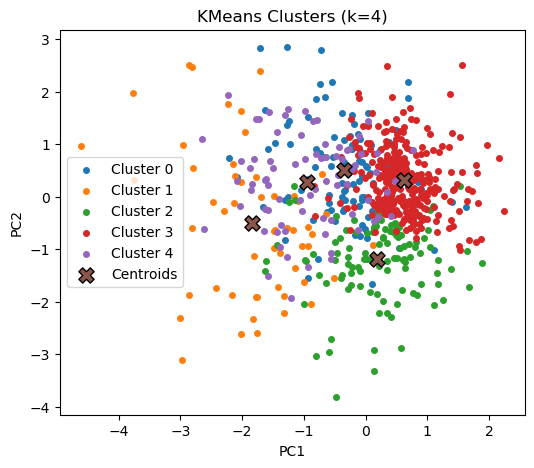

In [123]:
plt.figure(figsize=(6,5))
for c in np.unique(labels):
    m = labels == c
    plt.scatter(PCA["PC1"][m], PCA["PC2"][m], s=16, label=f"Cluster {c}")

# Plot cluster centers (transform back to original scale for PC1/PC2 only)
centers_z = km.cluster_centers_
# Only the first two columns correspond to PC1/PC2 if feature_cols starts with them:
if feature_cols[:2] == ["PC1", "PC2"]:
    centers_xy = scaler.inverse_transform(
        np.column_stack([centers_z[:, :2], np.zeros((centers_z.shape[0], len(feature_cols)-2))])
    )[:, :2]
    plt.scatter(centers_xy[:,0], centers_xy[:,1], marker="X", s=120, edgecolor="k", label="Centroids")

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k=4)")
plt.legend()
plt.show()

In [124]:
merged_clusters = clusters_df.merge(player_df, on="dg_id", how="inner")

In [125]:
merged_clusters.head()

,dg_id,season,PC1,PC2,sg_putt,sg_arg,sg_app,sg_ott,cluster,player_name
0,44,2024,-2.866253,2.514088,1.25950,-1.19450,-3.05550,-0.7565,1,"Couples, Fred"
1,612,2024,-1.704198,2.391196,-0.65350,-0.80400,-2.49850,-2.9090,1,"Blake, Jay Don"
2,653,2024,-0.738376,0.822678,-0.51075,-0.01275,-0.48375,-0.6705,0,"Singh, Vijay"
3,863,2024,-2.955729,0.978874,-1.48800,-1.33650,-2.73000,-3.5900,1,"Daly, John"
4,874,2024,-4.610552,0.970299,-2.10600,0.35500,-4.93400,-0.8790,1,"Els, Ernie"


In [126]:
highlighted_players = ["DeChambeau, Bryson", "McIlroy, Rory", "Fleetwood, Tommy", "Thomas, Justin"]

dg_ids = merged_clusters[merged_clusters["player_name"].isin(highlighted_players)]["dg_id"].values

In [127]:
dg_ids

array([10091, 12294, 14139, 19841])

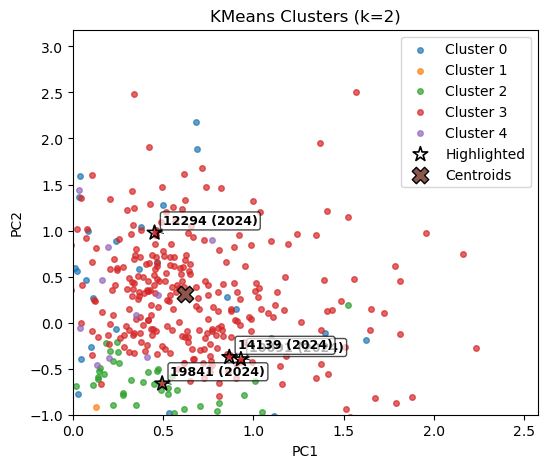

In [128]:
# ids you want to call out
highlight_ids = dg_ids  # <- change this

# if your plotted DataFrame is PCA and labels align 1:1:
plot_df = PCA.copy()
plot_df["cluster"] = labels

plt.figure(figsize=(6,5))
for c in np.unique(labels):
    m = plot_df["cluster"] == c
    plt.scatter(plot_df.loc[m, "PC1"], plot_df.loc[m, "PC2"], s=16, label=f"Cluster {c}", alpha=0.7)

# overlay highlights (thicker edge, bigger marker)
hl = plot_df["dg_id"].isin(highlight_ids)
plt.scatter(plot_df.loc[hl, "PC1"], plot_df.loc[hl, "PC2"],
            s=120, marker="*", edgecolor="k", linewidths=1.2, facecolors="none", zorder=5, label="Highlighted")

# annotate each highlighted point
for _, r in plot_df.loc[hl, ["dg_id","season","PC1","PC2"]].iterrows():
    plt.annotate(f"{int(r.dg_id)} ({int(r.season)})",  # text: dg_id (season)
                 (r.PC1, r.PC2),
                 xytext=(6,6), textcoords="offset points",
                 fontsize=9, weight="bold",
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
                 arrowprops=dict(arrowstyle="->", lw=0.6))

# (optional) plot centroids if you computed centers_xy
try:
    plt.scatter(centers_xy[:,0], centers_xy[:,1], marker="X", s=140, edgecolor="k", zorder=6, label="Centroids")
except NameError:
    pass

plt.xlim(left=0)      # PC1 >= 0 on the x-axis
plt.ylim(bottom=-1)   # PC2 >= -1 on the y-axis

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k})")
plt.legend()
plt.show()


In [129]:
merged_clusters[merged_clusters["dg_id"].isin(dg_ids)]

,dg_id,season,PC1,PC2,sg_putt,sg_arg,sg_app,sg_ott,cluster,player_name
83,10091,2024,0.930453,-0.398659,0.164658,0.180645,0.227039,0.740197,3,"McIlroy, Rory"
120,12294,2024,0.451779,0.976105,0.165333,0.225551,0.146833,0.287615,3,"Fleetwood, Tommy"
182,14139,2024,0.866204,-0.374567,-0.381474,0.486421,0.633789,0.188118,3,"Thomas, Justin"
355,19841,2024,0.494075,-0.661924,0.614857,0.529071,0.418714,1.393286,3,"DeChambeau, Bryson"
